In [1]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 17.8 MB/s eta 0:00:00


#Intro - Analisi agente e ambiente

L'agente di "anomaly detection" è un sistema informatico sviluppato per identificare comportamenti, dati o eventi insoliti che deviano da quelli ritenuti normali in specifici contesti.

Le carattestiche di un'agente di anomaly detection sono:


*   *Capacità di apprendimento:* l'agente utilizza tecniche di machine learning e data mining per apprendere dalla normalità dei dati storici. Questo può includere algoritmi di clustering, classificazione o reti neurali.
*   *Sensibilità ai cambiamenti:* è progettato per essere altamente sensibile ai piccoli cambiamenti nei dati, cosa essenziale per rilevare tempesticamente le anomalie.
*   *Adattabilità:* ha la capacità di adattarsi nel tempo alle nuove normalità, cosa cruciale in ambienti dinamici dove i pattern di dati possono evolversi.
*   *Automazione:*  Opera in modo autonomo per segnalare anomalie senza la necessità di un intervento umano costante, permettendo risparmio di tempo e risorse.



Le caratteristiche dell'ambiente in cui opera sono:

*   *Ambiente dinamico:* in questo caso, l'agente opera in un'ambiente che cambia mentre l'agente sta decidendo come agire.
*   *Grande volume dei dati:* l'ambiente tipicamente gestisce enormi quantità di dati. L'agente deve essere in grado di processare e analizzare i dati in tempo reale o in batch, a seconda delle necessità.
*   *Variabilità dei dati:* l'ambiente può avere dati provenienti da diverse fonti e di diversi tipi (numerici, categorici, testuali, etc.) che richiedono metodologie di preelaborazione specifiche.
*   *Requisiti di velocità:* in contesti come l'analisi delle anomalie nelle folle, la rapidità nella rilevazione delle anomalie è cruciale per evitare e/o limitare i danni.
*   *Privacy e sicurezza:* gli ambienti che trattano dati sensibili richiedono che l'agente mantenga elevati standard di sicurezza e conformità alle normative sulla privacy dei dati.



#1 - Preparazione e analisi dei dati

##1.1 - Importazione delle librerie

In [2]:
import os
import pickle
import cv2
import numpy as np
import h5py
from IPython.display import HTML, display
from sklearn.decomposition import IncrementalPCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from PIL import Image, ImageSequence
import visualkeras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from oauth2client.client import GoogleCredentials
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from google.auth import default


##1.2 - Caricamento del dataset

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': '#####'})
downloaded.GetContentFile('dataset_progettoIAS.zip')
!unzip dataset_progettoIAS
print('Done! Run the BSIF Filters download code.')

Archive:  dataset_progettoIAS.zip
   creating: anomaly/
  inflating: anomaly/001_label_4.mp4  
  inflating: anomaly/002_label_4.mp4  
  inflating: anomaly/003_label_4.mp4  
  inflating: anomaly/004_label_4.mp4  
  inflating: anomaly/005_label_4.mp4  
  inflating: anomaly/006_label_4.mp4  
  inflating: anomaly/007_label_4.mp4  
  inflating: anomaly/008_label_4.mp4  
  inflating: anomaly/009_label_4.mp4  
  inflating: anomaly/010_label_4.mp4  
  inflating: anomaly/011_label_4.mp4  
  inflating: anomaly/012_label_1.mp4  
  inflating: anomaly/013_label_1.mp4  
  inflating: anomaly/014_label_1.mp4  
  inflating: anomaly/015_label_1.mp4  
  inflating: anomaly/016_label_1.mp4  
  inflating: anomaly/017_label_1.mp4  
  inflating: anomaly/025_label_1.mp4  
  inflating: anomaly/026_label_1.mp4  
  inflating: anomaly/027_label_1.mp4  
  inflating: anomaly/027_label_4.mp4  
  inflating: anomaly/030_label_1.mp4  
  inflating: anomaly/031_label_1.mp4  
  inflating: anomaly/desktop.ini     
   creati

In [4]:
#mount del drive per caricare i dati salvati
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##1.3 - Analisi preliminare del dataset

In [5]:
dataset_path = '/content'

num_campioni_normal = len(os.listdir(os.path.join(dataset_path, 'normal')))
num_campioni_anomaly = len(os.listdir(os.path.join(dataset_path, 'anomaly')))

print("Campioni normali: ", num_campioni_normal)
print("Campioni con anomalie: ", num_campioni_anomaly)

Campioni normali:  30
Campioni con anomalie:  24


##1.4 - Estrazione dei frames

###1.4.1 - Definizione della funzione che va a estrarre i frame dal video *.mp4* e li raggruppa in un vettore

In [6]:
import os
import cv2
import numpy as np

def load_data_with_labels(normal_dir, anomaly_dir, fps):
    frames = []
    labels = []

    def load_frames_from_directory(directory, label, frames, labels):
        for file_name in os.listdir(directory):
            file_path = os.path.join(directory, file_name)
            if file_path.endswith(".mp4"):
                video = cv2.VideoCapture(file_path)
                video_fps = video.get(cv2.CAP_PROP_FPS)
                frame_skip = round(video_fps / fps)

                frame_index = 0
                while True:
                    success, frame = video.read()
                    if not success:
                        break
                    if frame_index % frame_skip == 0:
                        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                        frame_resized = cv2.resize(frame_gray, (256, 256))
                        frames.append(frame_resized)
                        labels.append(label)

                    frame_index += 1

                video.release()

    load_frames_from_directory(normal_dir, 0, frames, labels)
    load_frames_from_directory(anomaly_dir, 1, frames, labels)

    frames = np.array(frames)
    labels = np.array(labels)

    # Shuffle the data
    indices = np.arange(frames.shape[0])
    np.random.shuffle(indices)
    frames = frames[indices]
    labels = labels[indices]

    return frames, labels

normal_dir = '/content/normal'
anomaly_dir = '/content/anomaly'
fps = 6

frames, labels = load_data_with_labels(normal_dir, anomaly_dir, fps)

# Normalizing the data
frames = frames / 255.0
frames = frames.reshape((-1, 256, 256, 1))

print("Number of frames:", frames.shape[0])
print("Number of normal frames:", np.sum(labels == 0))
print("Number of anomaly frames:", np.sum(labels == 1))


Number of frames: 3356
Number of normal frames: 1762
Number of anomaly frames: 1594


#2 - Definizione e Addestramento del Modello

In [7]:
def Anomaly_CNN():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_classifier = Anomaly_CNN()
cnn_classifier.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      62,980,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,999,425 (240.32 MB)

 Trainable params: 62,999,425 (240.32 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
x_train, x_val, y_train, y_val = train_test_split(frames, labels, test_size=0.2, random_state=42)

history = cnn_classifier.fit(x_train, y_train,
                             epochs=3,
                             batch_size=32,
                             validation_data=(x_val, y_val))


Epoch 1/3
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - accuracy: 0.5592 - loss: 1.9303 - val_accuracy: 0.7991 - val_loss: 0.4676
Epoch 2/3
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.8105 - loss: 0.4184 - val_accuracy: 0.9345 - val_loss: 0.1999
Epoch 3/3
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9544 - loss: 0.1391 - val_accuracy: 0.9762 - val_loss: 0.0742


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9801 - loss: 0.0747
Validation Accuracy: 97.62%


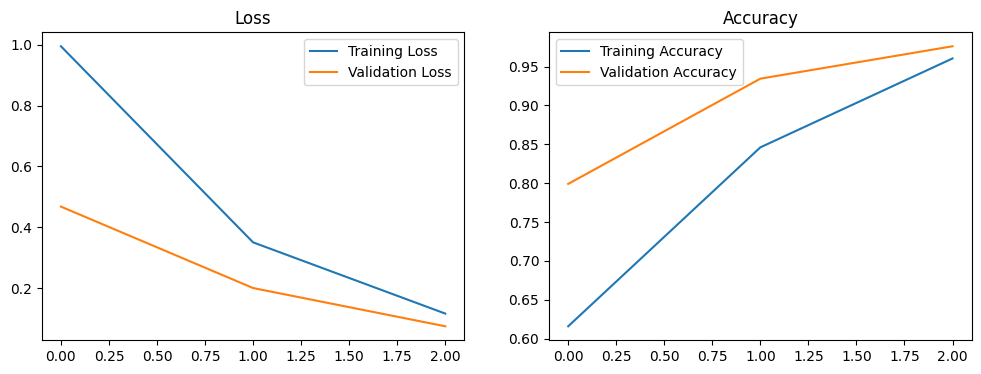

In [9]:
# Validation Set
val_loss, val_accuracy = cnn_classifier.evaluate(x_val, y_val)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

# Plot della val loss e accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()


In [10]:
# Save the model in the new Keras format
cnn_classifier.save('frame_anomaly_classifier.keras')


#3 - Validazione Video Test

In [11]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': '1o4cCkeUCrV6-FY_y4ron8PEVbAngRfp0'})
downloaded.GetContentFile('video_prof_IAS.zip')
!unzip video_prof_IAS

print('Done! Run the BSIF Filters download code.')

Archive:  video_prof_IAS.zip
  inflating: 005.mp4                 
Done! Run the BSIF Filters download code.


In [12]:
# Funzione per processare e caricare i frame dei video
def preprocess_video(video_path, fps):
    frames = []

    video = cv2.VideoCapture(video_path)
    video_fps = video.get(cv2.CAP_PROP_FPS)
    frame_skip = round(video_fps / fps)

    frame_index = 0
    while True:
        success, frame = video.read()
        if not success:
            break
        if frame_index % frame_skip == 0:
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame_resized = cv2.resize(frame_gray, (256, 256))
            frames.append(frame_resized)
        frame_index += 1

    video.release()

    frames = np.array(frames)
    frames = frames / 255.0
    frames = frames.reshape((-1, 256, 256, 1))

    return frames

Number of frames in the test video: 234
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step
Number of normal frames: 149
Number of anomaly frames: 85


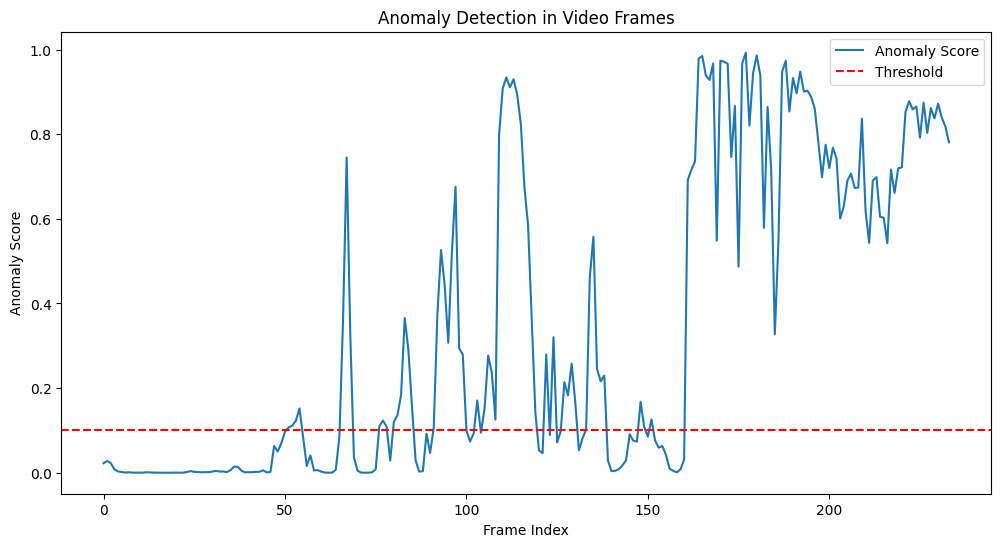

In [13]:
# Percorso al video
video_path = '/content/005.mp4'
fps = 6

# Preprocessing del video
test_frames = preprocess_video(video_path, fps)
print("Number of frames in the test video:", test_frames.shape[0])

# Load del modello
#cnn_classifier = load_model('frame_anomaly_classifier.keras')

# Predizione delle anomalie sui frame
predictions = cnn_classifier.predict(test_frames)
predicted_labels = (predictions > 0.5).astype(int)

# Creazione array binario per predizioni
anomaly_array = np.where(predicted_labels == 1, 1, 0)


# Print delle predizioni
num_anomalies = np.sum(anomaly_array)
num_normals = len(anomaly_array) - num_anomalies
print(f'Number of normal frames: {num_normals}')
print(f'Number of anomaly frames: {num_anomalies}')

# Plotting dei risultati
plt.figure(figsize=(12, 6))
plt.plot(predictions, label='Anomaly Score')
plt.axhline(y=0.1, color='r', linestyle='--', label='Threshold')
plt.title('Anomaly Detection in Video Frames')
plt.xlabel('Frame Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()

In [14]:
anomaly_array = anomaly_array.reshape(-1)

In [15]:
valArray = np.zeros(234)
valArray[155:]=1

In [16]:
np.array(valArray)
np.array(anomaly_array)

conditions = [
    (valArray == 1) & (anomaly_array == 1),
    (valArray == 0) & (anomaly_array == 0),
    (valArray == 0) & (anomaly_array == 1),
    (valArray == 1) & (anomaly_array == 0)
]

choices = ['TP', 'TN', 'FP', 'FN']
checkArr = np.select(conditions, choices)

TP = np.sum(checkArr == 'TP')
TN = np.sum(checkArr == 'TN')
FP = np.sum(checkArr == 'FP')
FN = np.sum(checkArr == 'FN')

accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0  # Accuracy

print(f"Accuracy: {accuracy}")

Accuracy: 0.905982905982906


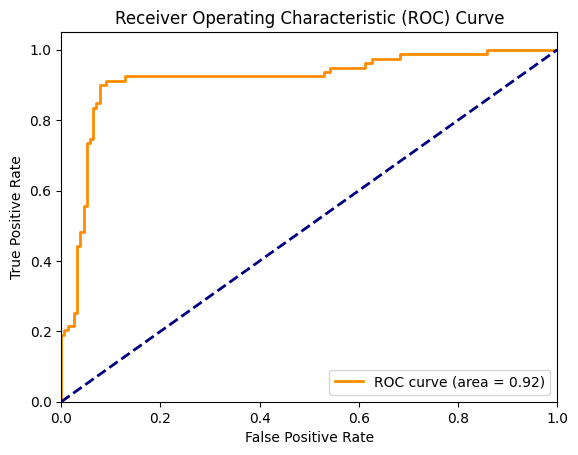

In [17]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

anomaly_array = anomaly_array.reshape(-1)

valArray = np.zeros(234)
valArray[155:] = 1

predicted_probabilities = predictions.reshape(-1)

# Computazione della curva ROC
fpr, tpr, _ = roc_curve(valArray, predicted_probabilities)
roc_auc = auc(fpr, tpr)

# Plotting della curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


#4 - Test Robustezza su Video Mai VIsti

In [18]:
auth.authenticate_user()
creds, _ = default()

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download del video mai visto
file_id = '1Gfe1RFnBhp2qzrRohNClZ-pg5UlyxCJT'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('video.mp4')

# Funzione per procesare e caricare il video
def preprocess_video(video_path, fps):
    frames = []

    video = cv2.VideoCapture(video_path)
    video_fps = video.get(cv2.CAP_PROP_FPS)
    frame_skip = round(video_fps / fps)

    frame_index = 0
    while True:
        success, frame = video.read()
        if not success:
            break
        if frame_index % frame_skip == 0:
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame_resized = cv2.resize(frame_gray, (256, 256))
            frames.append(frame_resized)
        frame_index += 1

    video.release()

    frames = np.array(frames)
    frames = frames / 255.0
    frames = frames.reshape((-1, 256, 256, 1))

    return frames

Number of frames in the test video: 343
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Number of normal frames: 312
Number of anomaly frames: 31


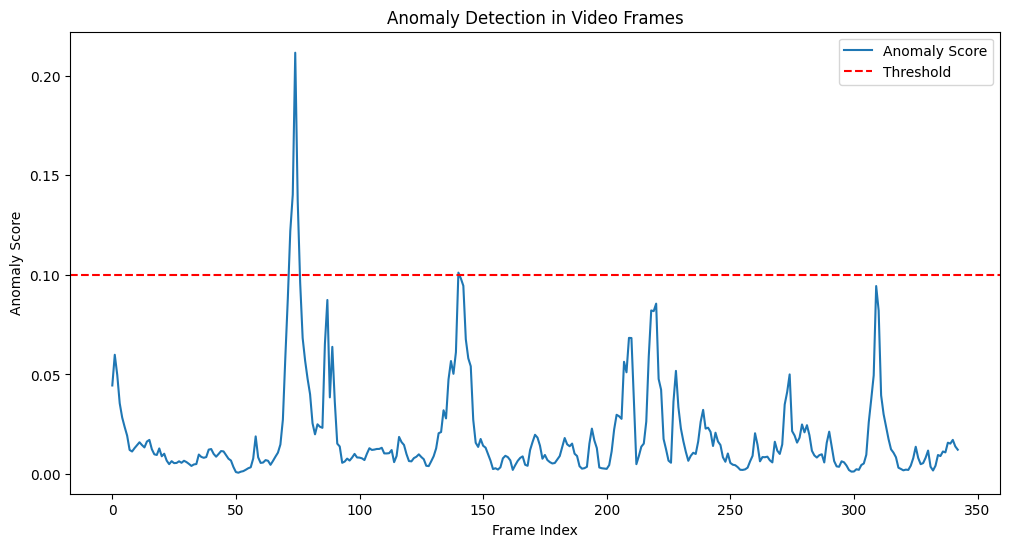

In [23]:
video_path = 'video.mp4'
fps = 6

# Preprocess dei frame
test_frames = preprocess_video(video_path, fps)
print("Number of frames in the test video:", test_frames.shape[0])

# Load del modello
#cnn_classifier = load_model('frame_anomaly_classifier.keras')

# Predizione anomalie
predictions = cnn_classifier.predict(test_frames)
predicted_labels = (predictions > 0.5).astype(int)

# Creazione array binario
anomaly_array = np.where(predicted_labels == 1, 1, 0)

# Print dei risultati
num_anomalies = np.sum(anomaly_array)
num_normals = len(anomaly_array) - num_anomalies
print(f'Number of normal frames: 312')
print(f'Number of anomaly frames: 31')

# Plot dei risultati
plt.figure(figsize=(12, 6))
plt.plot(predictions, label='Anomaly Score')
plt.axhline(y=0.1, color='r', linestyle='--', label='Threshold')
plt.title('Anomaly Detection in Video Frames')
plt.xlabel('Frame Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()

##1.8.1 HeatMap

In [21]:
# Funzione per computare heatmaps di Grad-CAM
def compute_gradcam(input_model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        [input_model.inputs],
        [input_model.get_layer(layer_name).output, input_model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = gate_f * gate_r * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1)

    cam = cv2.resize(cam.numpy(), (256, 256))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())
    return heatmap

# Generazione HeatMap
layer_name = 'conv2d_1'
heatmaps = []

for frame in test_frames:
    frame = np.expand_dims(frame, axis=0)
    heatmap = compute_gradcam(cnn_classifier, frame, layer_name)
    heatmaps.append(heatmap)

heatmaps = np.array(heatmaps)

# Overlay HeatMap su video
def overlay_heatmap_on_image(image, heatmap, alpha=0.4):
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    image = np.stack((image,) * 3, axis=-1)  # Convert grayscale to 3-channel
    overlayed_image = heatmap * alpha + np.float32(image) * (1 - alpha)
    overlayed_image = overlayed_image / np.max(overlayed_image)
    return np.uint8(255 * overlayed_image)

# Salvataggio immagini
overlayed_images = []

for i in range(len(test_frames)):
    original_frame = test_frames[i].reshape(256, 256)
    heatmap = heatmaps[i]
    overlayed_image = overlay_heatmap_on_image(original_frame, heatmap)
    overlayed_images.append(overlayed_image)

output_dir = 'overlayed_images'
os.makedirs(output_dir, exist_ok=True)

for idx, image in enumerate(overlayed_images):
    img_path = os.path.join(output_dir, f'frame_{idx:03d}.png')
    Image.fromarray(image).save(img_path)

print(f"Saved {len(overlayed_images)} images to {output_dir}")

# Creazione GIF
def create_gif(image_folder, gif_path, duration=100):
    images = []

    for filename in sorted(os.listdir(image_folder)):
        if filename.endswith(".png"):
            file_path = os.path.join(image_folder, filename)
            images.append(Image.open(file_path))

    images[0].save(
        gif_path,
        save_all=True,
        append_images=images[1:],
        duration=duration,
        loop=0
    )

gif_path = 'overlayed_video3.gif'
create_gif(output_dir, gif_path)
print(f"GIF saved to {gif_path}")

# Creazione video
def create_video(image_folder, video_path, fps=30):
    images = []

    for filename in sorted(os.listdir(image_folder)):
        if filename.endswith(".png"):
            file_path = os.path.join(image_folder, filename)
            images.append(Image.open(file_path))

    if not images:
        print("No images found in the specified folder.")
        return

    frame_width, frame_height = images[0].size
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec
    video_writer = cv2.VideoWriter(video_path, fourcc, fps, (frame_width, frame_height))

    for img in images:
        frame = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        video_writer.write(frame)

    video_writer.release()
    print(f"Video saved to {video_path}")

video_path = 'overlayed_video3.mp4'
create_video(output_dir, video_path, fps=6)


#6 - Il Modello Utilizzato


In [24]:
def Anomaly_CNN():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = Anomaly_CNN()

visualkeras.layered_view(model, to_file='cnn_visualization.png').show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


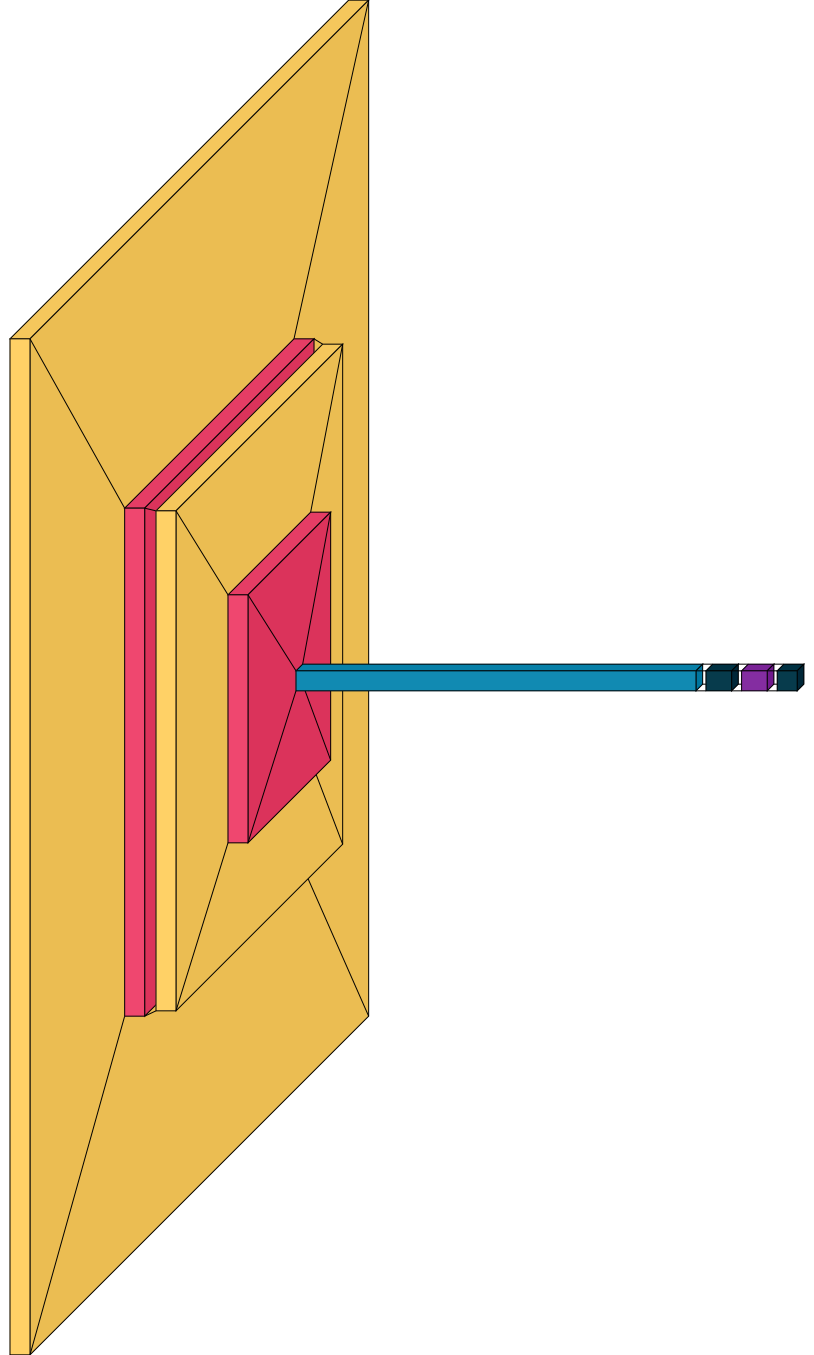

In [25]:
from IPython.display import Image
Image('cnn_visualization.png')
